In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dt = 0.01
N = 100
D = 1.0
np.random.seed(2985)
sigma = np.sqrt(2*D*dt)

e = np.random.normal(0, sigma, N-1)
B = np.zeros(N)
B[1:] = np.cumsum(e)

$e$ is our white Gaussian noise with drift value $D$. 
$W$ is our Wiener process (discrete Brownian Motion). 
$e$ can be thought of as $\Delta W$ for each time step of the Wiener process.

We can then create an Ornstein-Uhlenbeck process through the SDE:
$$
\frac{dx}{dt} = -kx + e
$$
where $k$ can be thought of as the spring constant (drag coefficient), and $e$ is the white Gaussian noise. 

We can then implement a numerical solution of this using the Euler-Maruyama method. This is done by converting the current form of our SDE back into 
$$
dx = -kxdt + dW
$$
From here we can then use the Euler-Maruyama method of:
$$
dx_t = a(x_t, t)dt + b(x_t, t)dW_t
$$
Can be approximated numerically by the following recursion:
$$
x_{n+1} = x_n + a(x_n, t_n)\Delta t + b(x_n, t_n) \Delta W_n
$$
where $\Delta t = T/N$, where $T$ is the time interval, $N$ is the total number of time steps, $\Delta W_n = e_n$, where $e_n$ is the white Gaussian noise at time step $n$. 

To apply this to our Ornstein-Uhlenbeck process we get:
$$
x_{n+1} = x_n - kx_n\Delta t + \Delta W_n
$$

I will now implement the Euler-Maruyama method that can be applied to a given Ornstein-Uhlenbeck process.

In [3]:
def EulerMaruyamaRecursion(x_n, k, dt, e_n):
    '''
    Return the x_{n+1} value using the Euler-Maruyama method recursion.
    '''
    return x_n - k*x_n*dt + e_n

def EulerMaruyamaMethod(x_0, k, T_lim, N, D):
    '''
    Complete the Euler-Maruyama method and return the approximated x values at each time value.
    '''
    dt = (T_lim[1] - T_lim[0])/N

    t = np.arange(T_lim[0], T_lim[1]+dt, dt)

    x = np.zeros(N+1)
    x[0] = x_0

    sigma = np.sqrt(2*D*dt)
    e = np.random.normal(0, sigma, N)

    for n in range(N):
        x[n+1] = EulerMaruyamaRecursion(x[n], k, dt, e[n])

    return t, x


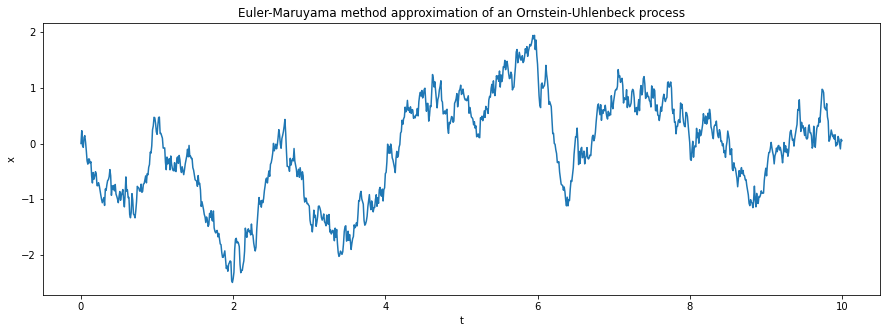

In [34]:
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
plt.figure(figsize=(15, 5))
plt.title('Euler-Maruyama method approximation of an Ornstein-Uhlenbeck process')
plt.plot(t, x)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Realisation of a simple Ornstein-Uhlenbeck process.

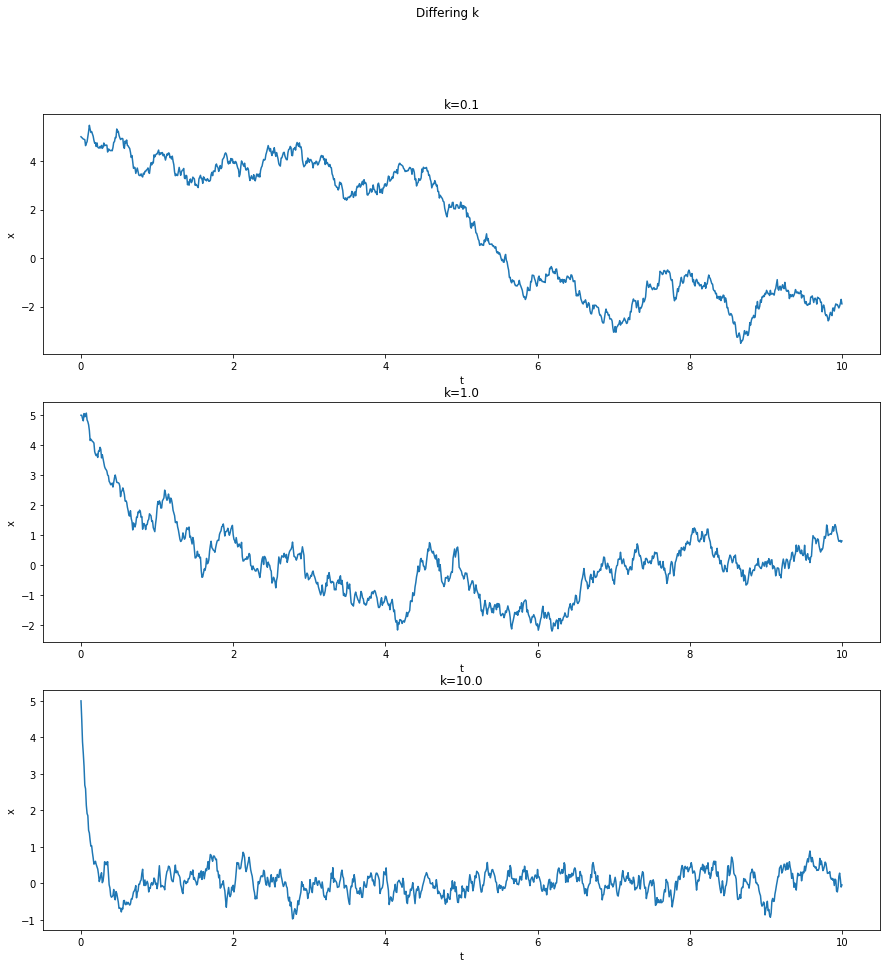

In [33]:
x_0 = 5.0
k_vals = np.array([0.1, 1.0, 10.0])
T_lim = np.array([0, 10])
N = 1000
D = 1.0
fig, axi = plt.subplots(np.size(k_vals, 0), figsize=(15, 15))
fig.suptitle('Differing k')

for i, k in enumerate(k_vals):
    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    axi[i].plot(t, x)
    axi[i].set_title(f'k={k}')
    axi[i].set_xlabel('t')
    axi[i].set_ylabel('x')



By differing k values, I can see that it effects how quickly it tends to 0 from starting in a displaced position. This makes sense in terms of a spring constant, as a stiffer spring, a higher k value, will result in the mass being pulled into the equilibrium faster and then in the future will deviate from the equilibrium less. And the opposite is true for a less stiff spring, lower k value, where it still tends towards the equilibrium but not as fast.

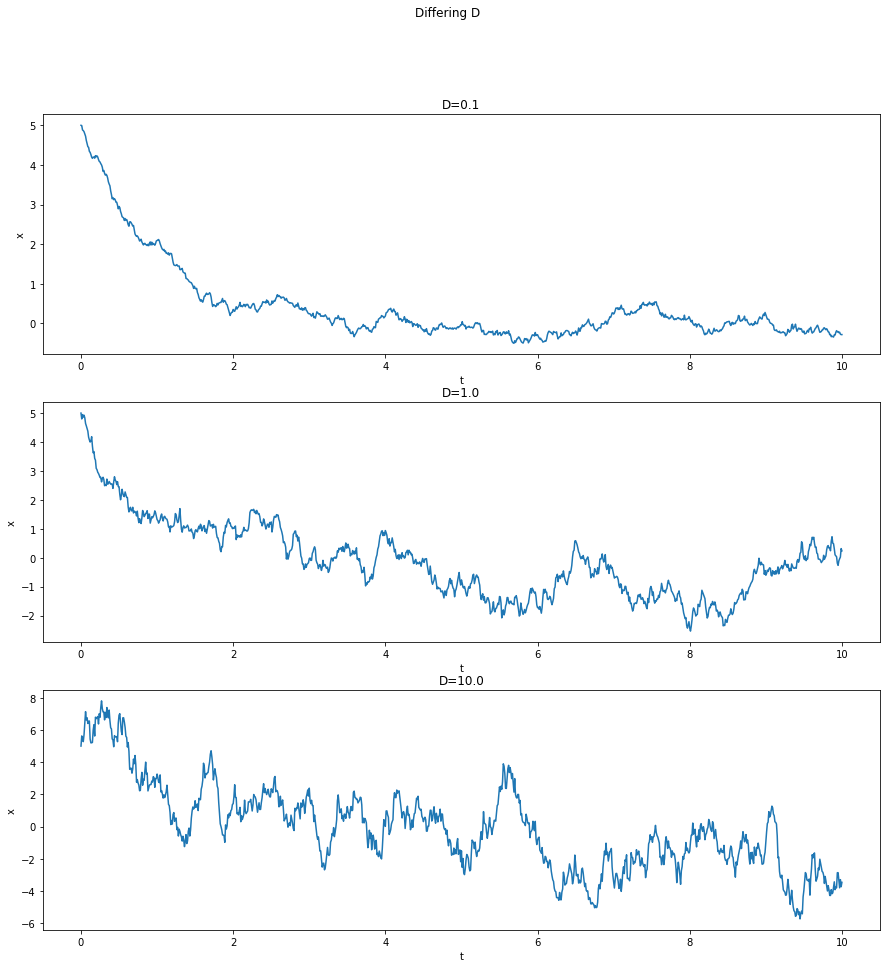

In [35]:
x_0 = 5.0
k = 1.0
T_lim = np.array([0, 10])
N = 1000
D_vals = np.array([0.1, 1.0, 10.0])
fig, axi = plt.subplots(np.size(D_vals, 0), figsize=(15, 15))
fig.suptitle('Differing D')

for i, D in enumerate(D_vals):
    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    axi[i].plot(t, x)
    axi[i].set_title(f'D={D}')
    axi[i].set_xlabel('t')
    axi[i].set_ylabel('x')

By differing D values, I can see that it effects how smooth the process is. This makes sense as the drift value D is directly proportional to the variance of the white Gaussian noise in the model. I can see that the higher drift value D, the more it deviates from a smooth curve back to the equilibrium, creating larger peaks and troughs about the equilibrium. The opposite is true for a smaller drift value D, with it being a much smoother process, not deviating too far from a smooth exponential curve back to the equilibrium. 

Next we can have a look at some approaches to finding estimates of the two parameters $k$ and $D$. 

We can start by setting $k=0$. Now we can see the problem as just:
$$
\frac{dx}{dt} = e
$$
which is simply just the Wiener process we have seen before. From this we can then make estimates of what $D$ will be from the values of $e$ as they will follow a Gaussian distribution of mean $0$ and variance $2Ddt$. So we can work out the estimate of the variance and then using values known for $dt$ we can work out $D$. As the mean is known $\mu = 0$, we can use the maximum likelihood estimator for the variance $\sigma^2$:
$$
\hat\sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (e_i)^2
$$
So then we can get an estimate of $D$ to be:
$$
D = \frac{\hat\sigma^2}{2dt}
$$

In [4]:
def EstimateVariance(x, T_lim, N):
    '''
    Return the maximum likelihood estimator of the variance when k=0
    '''
    dt = (T_lim[1]- T_lim[0])/N
    e = x[1:] - x[:-1]
    Var = np.sum(np.power(e, 2))/N
    return Var/(2*dt)

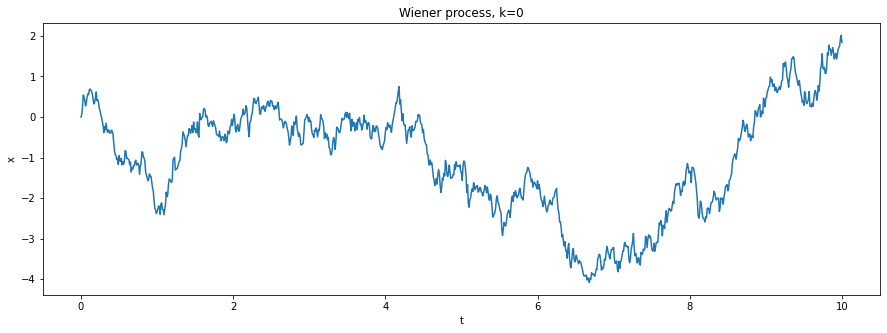

In [47]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
plt.figure(figsize=(15, 5))
plt.title('Wiener process, k=0')
plt.plot(t, x)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

In [48]:
print(f'The actual D value is: {D}')
print(f'The estimated D value is: {EstimateVariance(x, T_lim, N)}')

The actual D value is: 1.0
The estimated D value is: 0.9759055568200626


Now I have an approximation of D for one case. I can then repeat this over and over with different values of N to find out how the approximation converges to the actual value. I am also going to plot $D-\hat D$ so that it converges to 0, and this way I can square the difference $(D-\hat D)^2$ also to see that convergence also. The reason for squaring it, is because we have a suspicion that the convence will be proportional to $\sqrt(N)$ and such by squaring the difference should get a linear convergence. 

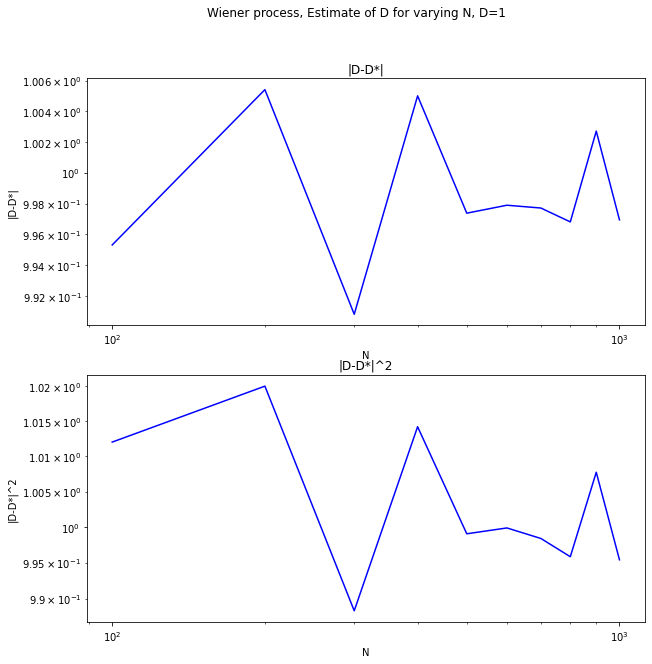

In [9]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N_vals = np.arange(100, 1100, 100)
D = 1.0
M = 100
D_prime = np.zeros((np.size(N_vals, 0), M))


fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Wiener process, Estimate of D for varying N, D=1')
axi[0].set_title(f'|D-D*|')
axi[0].set_xlabel('N')
axi[0].set_ylabel('|D-D*|')
axi[0].set_yscale('log')
axi[0].set_xscale('log')

axi[1].set_title(f'|D-D*|^2')
axi[1].set_xlabel('N')
axi[1].set_ylabel('|D-D*|^2')
axi[1].set_yscale('log')
axi[1].set_xscale('log')

for i, N in enumerate(N_vals):
    for j in range(M):
        t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
        D_prime[i, j] = EstimateVariance(x, T_lim, N)
        
        #axi[0].scatter(N, D_prime[i, j], c='r')
        #axi[1].scatter(N, D_prime[i, j]**2, c='r')


axi[0].plot(N_vals, np.mean(D_prime, axis=1), c='b')
axi[1].plot(N_vals, np.mean(np.power(D_prime, 2), axis=1), c='b')
plt.show()






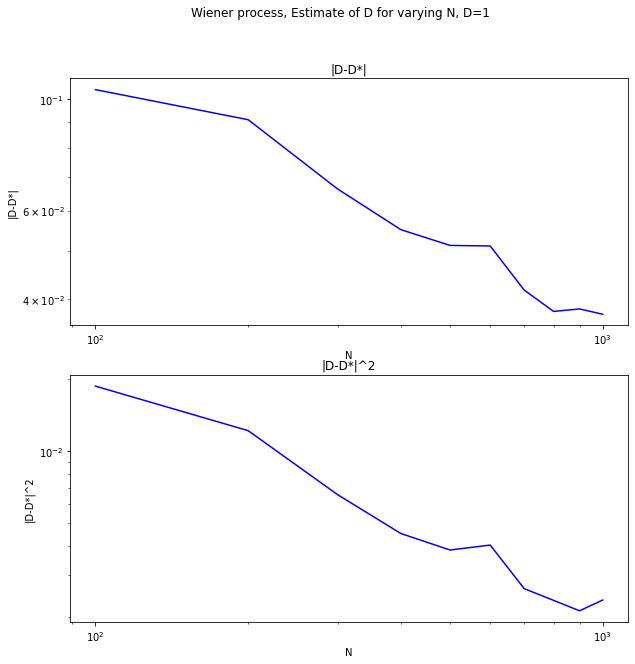

In [8]:
fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Wiener process, Estimate of D for varying N, D=1')
axi[0].set_title(f'|D-D*|')
axi[0].set_xlabel('N')
axi[0].set_ylabel('|D-D*|')
axi[0].set_yscale('log')
axi[0].set_xscale('log')

axi[1].set_title(f'|D-D*|^2')
axi[1].set_xlabel('N')
axi[1].set_ylabel('|D-D*|^2')
axi[1].set_yscale('log')
axi[1].set_xscale('log')
axi[0].plot(N_vals, np.mean(D_prime, axis=1), c='b')
axi[1].plot(N_vals, np.mean(np.power(D_prime, 2), axis=1), c='b')
plt.show()

In [ ]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N_vals = np.arange(100, 1100, 100)
D = 1.0
M = 100
D_prime = np.zeros((np.size(N_vals, 0), M))


fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Wiener process, Estimate of D for varying N, D=1')
axi[0].set_title(f'|D-D*|')
axi[0].set_xlabel('N')
axi[0].set_ylabel('|D-D*|')
axi[0].set_yscale('log')
axi[0].set_xscale('log')

axi[1].set_title(f'|D-D*|^2')
axi[1].set_xlabel('N')
axi[1].set_ylabel('|D-D*|^2')
axi[1].set_yscale('log')
axi[1].set_xscale('log')

for i, N in enumerate(N_vals):
    for j in range(M):
        t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
        D_prime[i, j] = EstimateVariance(x, T_lim, N)
        
        #axi[0].scatter(N, D_prime[i, j], c='r')
        #axi[1].scatter(N, D_prime[i, j]**2, c='r')


axi[0].plot(N_vals, np.mean(D_prime, axis=1), c='b')
axi[1].plot(N_vals, np.mean(np.power(D_prime, 2), axis=1), c='b')
plt.show()

From the above plots can see that as N increaes the mean estimates of D converge. 

I now want to consider a fixed N, but varying the amount of times I repeat the simulation. In the previous I set this at 100, but now I am going to vary this to see how this affects the mean estimate. I am now just going to use the $|D-D'|^2$ value and plot the distribution.

In [77]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
M_vals = np.arange(100, 1100, 100)
D_prime = [np.zeros(M) for M in M_vals]


fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Wiener process, Estimate of D for varying N, D=1')
axi[0].set_title(f'|D-D*|')
axi[0].set_xlabel('M')
axi[0].set_ylabel('|D-D*|')

axi[1].set_title(f'|D-D*|^2')
axi[1].set_xlabel('M')
axi[1].set_ylabel('|D-D*|^2')

for i, M in enumerate(M_vals):
    for j in range(M):
        t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
        D_prime[i][j] = np.abs(D-EstimateVariance(x, T_lim, N))
        axi[0].scatter(M, D_prime[i][j], c='r')
        axi[1].scatter(M, D_prime[i][j]**2, c='r')


axi[0].plot(M_vals, [np.mean(i) for i in D_prime], c='b')
axi[1].plot(M_vals, [np.mean(np.power(i, 2)) for i in D_prime], c='b')
plt.show()


TypeError: power() takes from 2 to 3 positional arguments but 1 were given

Error in callback <function flush_figures at 0x00000162F401DD80> (for post_execute):


KeyboardInterrupt: 

The plots above show the mean estimate for a varying amount of simulations can still vary as simulations increase, but from the graph, as M is nearing 200, the estimate remains very similar and such by increasing the simulations the mean estimate converges to a value which can be taken as the actual estimate.

I can now plot the distribution of estimates like Figure 2 to see what it looks like.

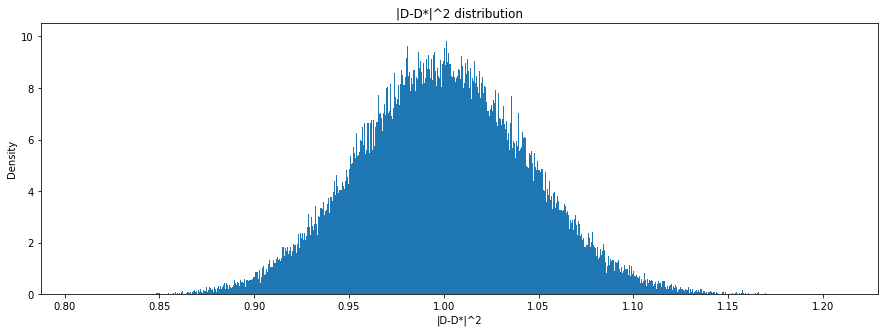

In [11]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
M = 100000
D_prime = np.zeros(M)


plt.figure(figsize=(15, 5))
plt.title('|D-D*|^2 distribution')
plt.xlabel('|D-D*|^2')
plt.ylabel('Density')

for i in range(M):

    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_prime[i] = EstimateVariance(x, T_lim, N)
   

plt.hist(D_prime, bins=1000, density=True)
plt.show()

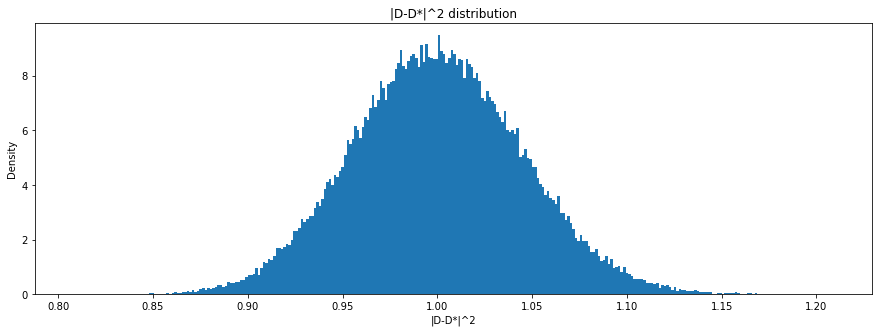

In [12]:
plt.figure(figsize=(15, 5))
plt.title('|D-D*|^2 distribution')
plt.xlabel('|D-D*|^2')
plt.ylabel('Density')
plt.hist(D_prime, bins=300, density=True)
plt.show()

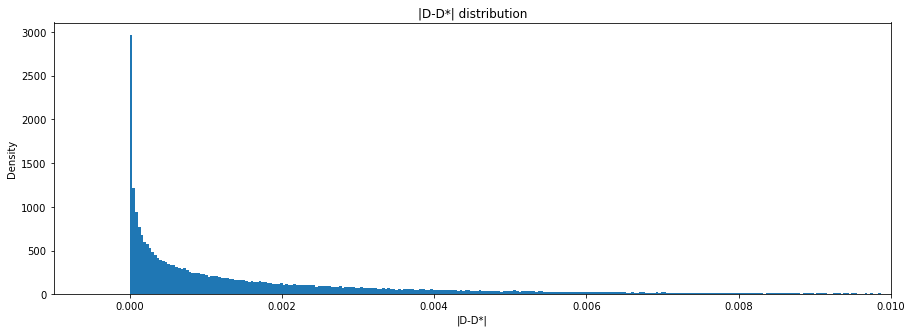

In [86]:
x_0 = 0.0
k = 0.0
T_lim = np.array([0, 10])
N = 1000
D = 1.0
M = 100000
D_prime = np.zeros(M)


plt.figure(figsize=(15, 5))
plt.title('|D-D*|^2 distribution')
plt.xlabel('|D-D*|^2')
plt.ylabel('Density')
plt.xlim([-0.001, 0.01])
for i in range(M):

    t, x = EulerMaruyamaMethod(x_0, k, T_lim, N, D)
    D_prime[i] = (D-EstimateVariance(x, T_lim, N))**2
   

plt.hist(D_prime, bins=1000, density=True)
plt.show()

From this plot we can imagine what the distribution of the estimates are when you square the difference between the estimate and the actual value of D.

From the above prints I can see that the formula can give an accurate value of D for when k=0. However one thing I notice is that after repeating a few times, the estimate is always below the actual value. This means that the maximum likelihood estimator produces an underestimate of the actual value. 

This approach works for $k=0$, but now I will attempt it for $k>0$. This time it will be useful to take the covariance between diffrent $x$ values instead of just taking the differences. I have found the covariance for a Ornstein-Uhlenbeck process to be:
$$
Cov(X_s X_t) = \frac{D}{K}e^{-k|t-s|}
$$
So now I can calculate the auto covariance in the generated sample and then plot it to find values for k and D. 

Using what we discussed in our meeting, I can change the method of generation of the Ornstein-Uhlenbeck process to be randomly picked from a normal distribution. This is so that the mean of the process over different simulations will be equal to 0, as it will be like it has been taken at an infinite time step. This is because the actual mean of an Ornstein-Uhlenbeck process isn't equal to 0, it is equal to:
$$
E(x_t) = x_0e^{-kt}
$$
where $x_0$ is the intial value. 

The reason we can't set $x_0=0$ is because of the same reason we can't start it at any other value, because we will have to disregard the first $\frac{5}{k}$ points such that the starting distribution matches the Gaussian distribution because the Ornstein-Uhlenbeck process is a Gaussian process. 

However I am not currently sure what the variance of the total distribution should be!!!

So until i figure out what the variance of limiting distribution is, I will instead use the discard method described above. This should give enough time such that the process is normalised and such that the mean is minimal, essentially zero. This is neccessary for working out the covariance of the process as then we will only need the expectation between two points and not the mean of both of them. That is:
$$
Cov(x_t x_{t+\tau}) = E(x_t x_{t+\tau}) - E(x_t) E(x_{t+\tau})
$$
But we will assume:
$$
E(x_t)=0,  E(x_{t+\tau})=0
$$
So we reult in:
$$
Cov(x_t x_{t+\tau}) = E(x_t x_{t+\tau})
$$
So to get this expectation value, with a known mean to be 0, will result in the same method as before with the sample mean of the two values to be:
$$
E(x_t x_{t+\tau}) = \frac{1}{n-\tau} (\sum_{i=0}^{n-\tau} x_i x_{i+\tau})
$$

In [5]:
def EstimateCovariance(x, N, tau):
    '''
    Return the maximum likelihood estimator of the autocovariance of tau
    '''
    cov = 0
    for i in range(N-tau):
        cov += x[i]*x[i+tau]
    cov = cov/(N-tau)
    return cov

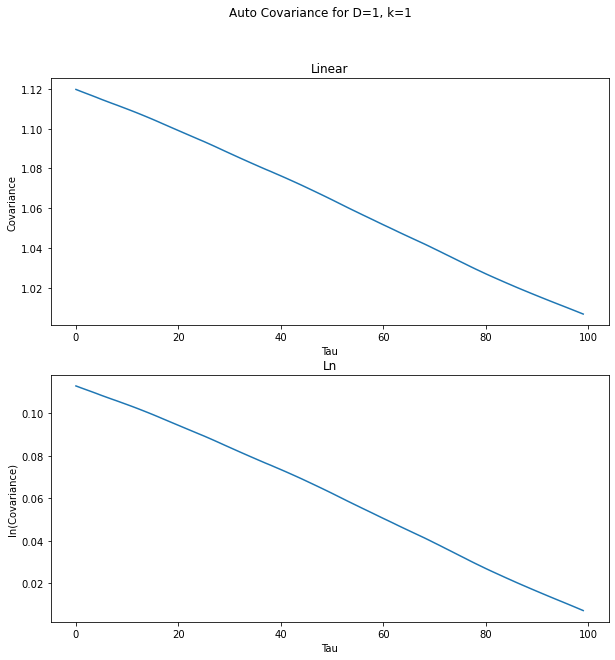

In [45]:
x_0 = 0.0
k = 1.0
T_lim = np.array([0, 10])
N = 10000
D = 1.0
min_t = int(np.ceil(5/k))
min_N = int(min_t*N/(T_lim[1]-T_lim[0]))
T_lim[0] -= min_t
t, x_prime = EulerMaruyamaMethod(x_0, k, T_lim, N + min_N, D)
x = x_prime[min_N+1:]
n = int(np.ceil(np.sqrt(N)))
taus = np.arange(n)
cov = np.zeros(n)
for i, tau in enumerate(taus):
    cov[i] = EstimateCovariance(x, N, tau)



fig, axi = plt.subplots(2, figsize=(10, 10))
fig.suptitle('Auto Covariance for D=1, k=1')

axi[0].plot(taus, cov)
axi[0].set_title(f'Linear')
axi[0].set_xlabel('Tau')
axi[0].set_ylabel('Covariance')

axi[1].plot(taus, np.log(cov))
axi[1].set_title(f'Ln')
axi[1].set_xlabel('Tau')
axi[1].set_ylabel('ln(Covariance)')
plt.show()

So now I have created a method of plotting the Auto Covariance sequence I can now strt to find out what k and D are from it. On the log/lin plot I can work it out to be $ln(Cov) = ln(\frac{k}{D}) - \tau$ which shows me that the y intercept will be equal to $ln(\frac{k}{D})$ but also that the x intercept will be equal to $ \tau = ln(\frac{k}{D})$.